# Introduction and First Hands-On to Multi-Head Attention

*by Raul Sanchez-Vazquez*

The paper [Attention is all you need](https://arxiv.org/abs/1706.03762)

This notebook is greatly inspired by the narrative of the following tutorial:

- [Illustrated Guide to Transformers Neural Network: A step by step explanation](https://www.youtube.com/watch?v=4Bdc55j80l8). Images in this notebook are obtained from the video (feel free to have a look at the video first).

Also, the code implementation of the transformer was found in the following tutorial:
- [Pytorch Transformers from Scratch (Attention is all you need)](https://www.youtube.com/watch?v=U0s0f995w14&t=1711s), original code can be found in [here](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/transformer_from_scratch/transformer_from_scratch.py)

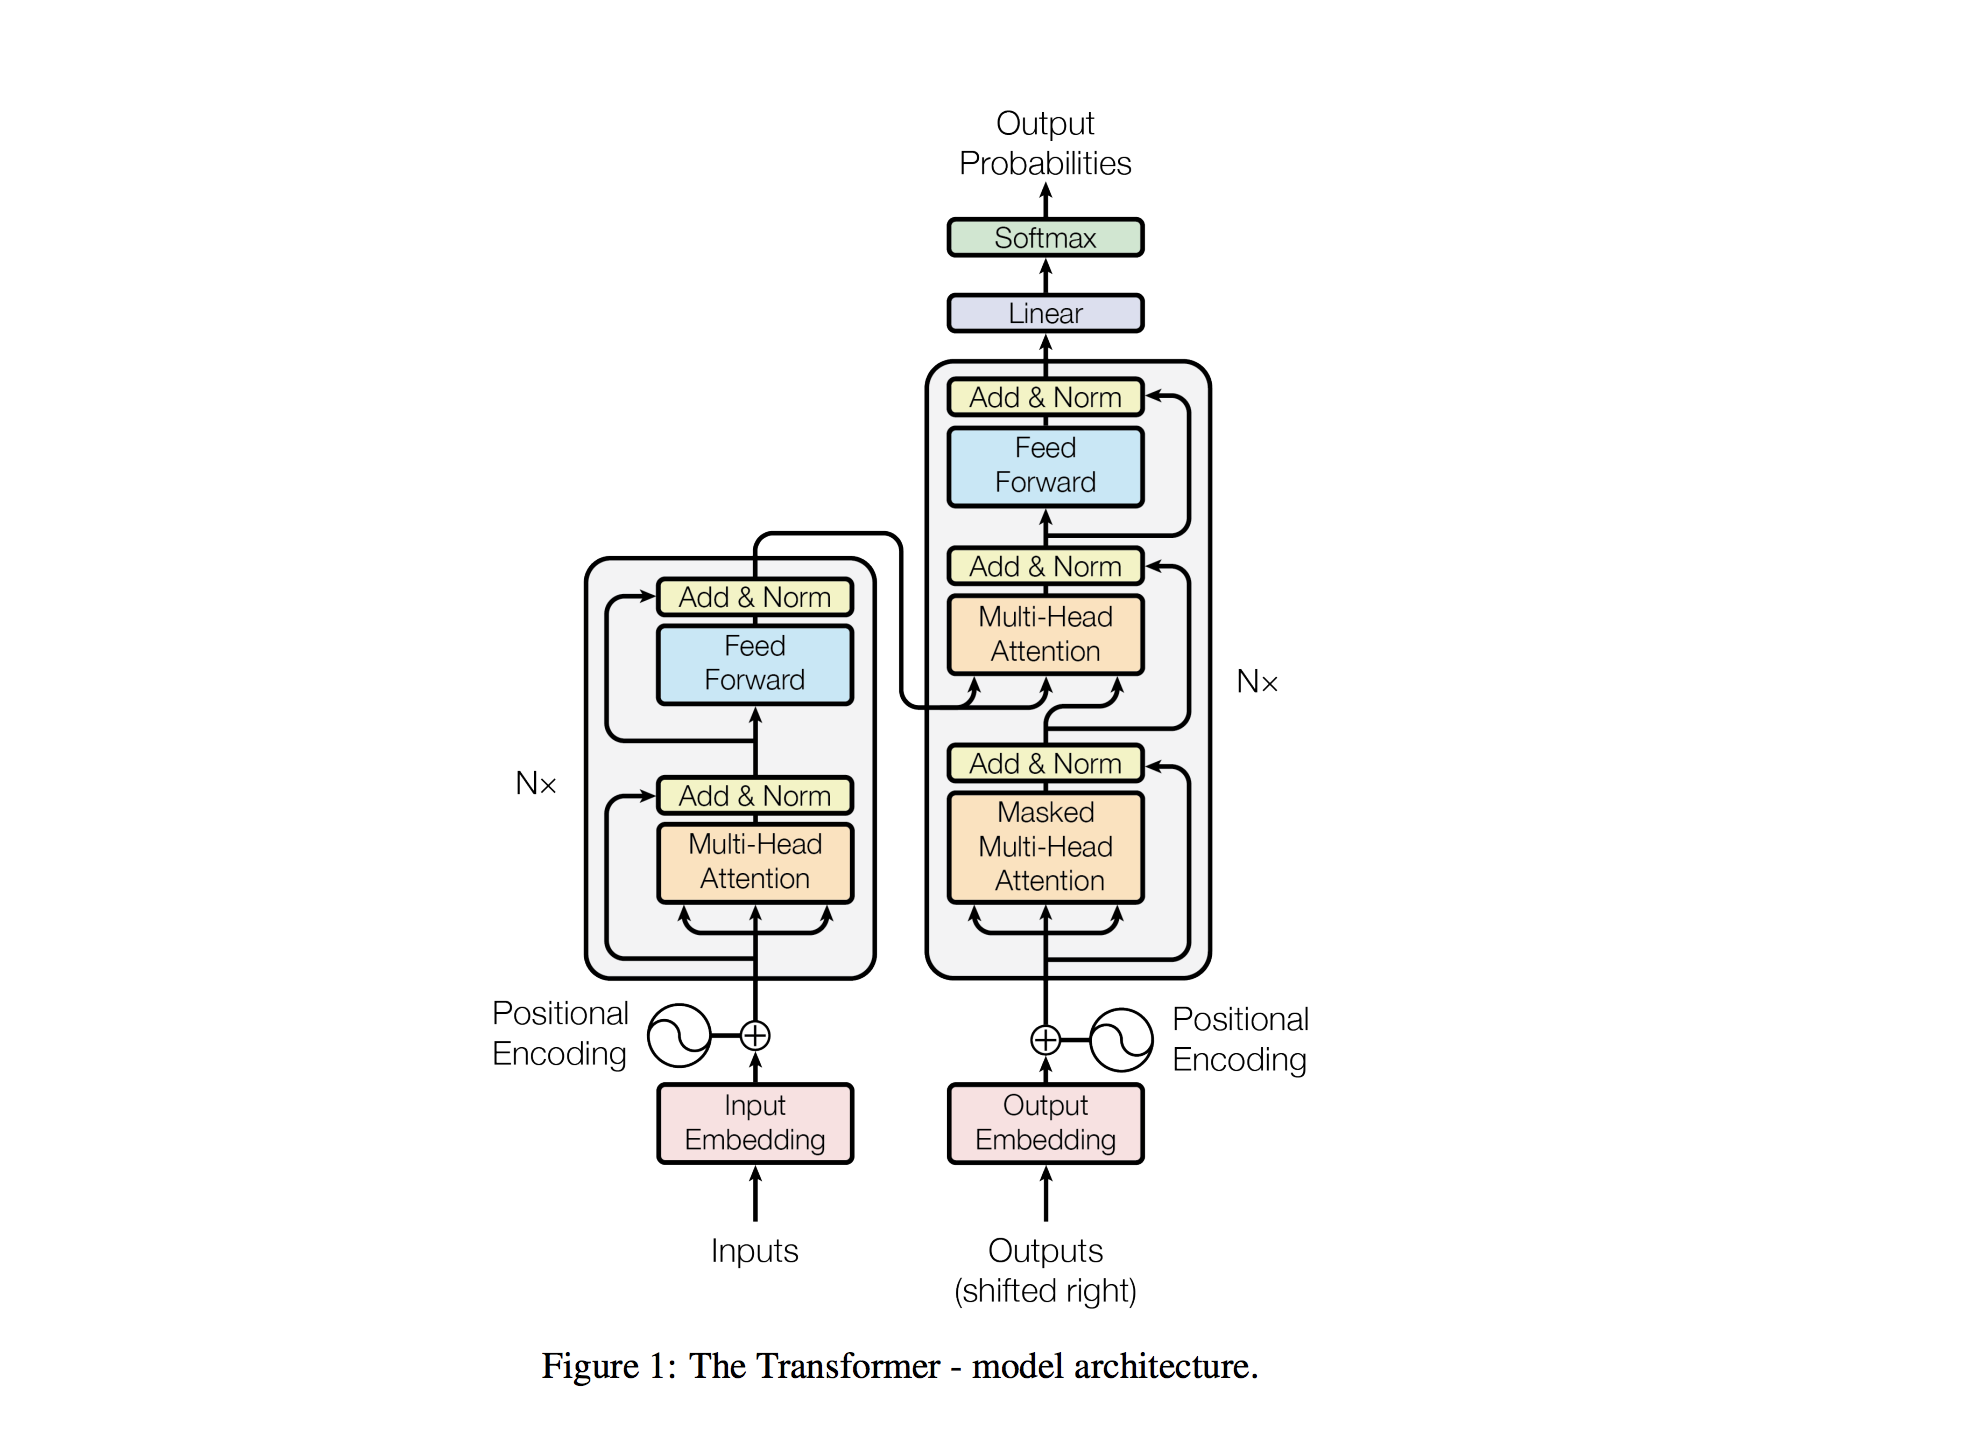

# Define parameters

In [1]:
import torch
import torch.nn as nn

# Number of tokens in our vocabulary
vocab_size = 10

# Number of dimensions to represent a token 
embed_size = 512

# Number of heads
# Set heads = 1 for educational purposes the first time approaching transformers.
heads = 2

# Max. length for the sequence
max_length = 15

# Head dimension
head_dim = embed_size // heads

# Token Representation and Positional Encoding

As one will observe later, word tokens are represented by vectors.

A token vector will carry information related to:
- 1) the semantics of the word 
- 2) and relative position of the word in the sequence it is found.

Word semantic is stored in a traditional **word embeddings** lookup table. Similarly, **positional embeddings** are also stored in a different lookup table.

A token vector will be composed by adding a word-embedding to its corresponding positiona-embedding.

As the word and positional vector embeddings are added up **they both need to have the same dimensions**.

In [2]:
## Generate a token embedding table.
# Each row represents a token 
# and each columns is a dimension in the token semantic space
word_embedding = nn.Embedding(vocab_size, embed_size)
word_embedding

Embedding(10, 512)

In [3]:
# Generate a positional embedding table.
# Each row represents a position of a word in the sequence
# and each columns is a dimension in the token semantic space (yes TOKEN semantic space).
position_embedding = nn.Embedding(max_length, embed_size)
position_embedding

Embedding(15, 512)

One could think that the word embedding and the position embeddings live in the same semantic space, as both the word and the position of the words in the sequence may add semantics to the actual representation of such token.

## Example

Initially, tokens are represented with a token index.

Using the token index and the position where it is found (both indices starting at 0), two vectors are fetched from the lookup tables and added together as illustrated in the diagram and the code bellow:

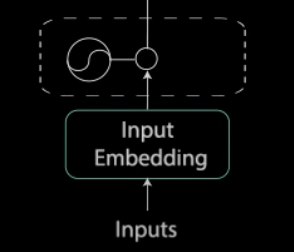

In [4]:
# Each item in the list is a sequence.
# Each index in a single sequence are token indices.
# For instance the index 0 may be the token: "How", the 1 may be the token "are", etc.
x_raw = torch.tensor([
    [0, 1, 2, 3],
    [1, 5, 6, 2]
])

# Get the number of sequences in the batch and their sequence length
N, seq_length = x_raw.shape

# Get the position index of each token.
positions = torch.arange(0, seq_length).expand(N, seq_length)
# Notice that `positions` is a sequencial vector from index 0 to the sequence length
# and there is one of such vectos from each sequence

# Fetch token embeddings and positional embeddings and add them up
x = word_embedding(x_raw) + position_embedding(positions)

In [5]:
# Finally x is the vector representation of the tokens and their positions
x.shape

torch.Size([2, 4, 512])

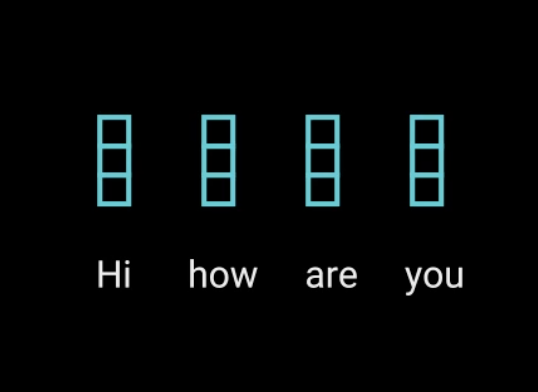

# Attention Mechanism

Next, the attention mechanism is achieved using the token embedding and three aditional vectors, namely: key, query, and value vectors. 

Such vectors are obtained by applying a transformation on the tokens via the three different linear layers below.

In [6]:
linear_layer_for_queries = nn.Linear(head_dim, head_dim, bias=False)
linear_layer_for_queries

Linear(in_features=256, out_features=256, bias=False)

In [7]:
linear_layer_for_keys = nn.Linear(head_dim, head_dim, bias=False)
linear_layer_for_keys

Linear(in_features=256, out_features=256, bias=False)

In [8]:
linear_layer_for_values = nn.Linear(head_dim, head_dim, bias=False)
linear_layer_for_values

Linear(in_features=256, out_features=256, bias=False)

## Heads

When using a single head the input size of the layers is the same as the token size (Set `heads = 1`).

When using multiple heads, as for this example: 2 heads, the original token vector is splitted in multiple equaly sized vectors, one vector for each head. Each of those smaller vectors are passed through the linear layers (query, key, and value). The layer input size is always smaller or equal than the token embedding size.

In this example, we use 2 heads, then the original vector of a token is splitted in two vectors of half of the size of the embedding size as shown below.

In [9]:
# Reshape x in order to fit in linear layers.
# Notice that the number of heads will split the token vector in a token-head vector.

# The firs dimension corresponds to the number of sequences
# The second dimension corresponds to the length of the sequence
# The third dimension corresponds to the number of heads
# The fourth dimension correspond to the size of the linear layer input

# The third and fourth dimensions combined are the original token representation.

x_reshape = x.reshape(x.shape[0], x.shape[1], heads, head_dim)
x_reshape.shape

torch.Size([2, 4, 2, 256])

In [10]:
# Get the query vectors
queries = linear_layer_for_queries(x_reshape)
queries.shape

torch.Size([2, 4, 2, 256])

In [11]:
# Get the key vectors
keys = linear_layer_for_keys(x_reshape)  # (N, key_len, heads, head_dim)
keys.shape

torch.Size([2, 4, 2, 256])

Doing a multiplication between the query and key vectors result in squared cross token information matrix.
You could think of this matrix as "how one word is related to other words in the sequence".

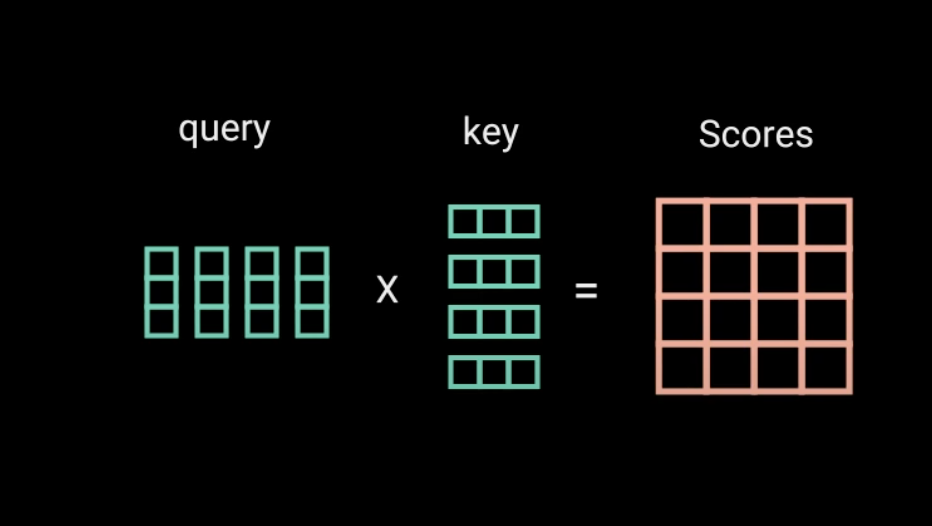

In [12]:
# Note Einsum does matrix mult. for query*keys for each training example
# with every other training example, don't be confused by einsum
# it's just how I like to do matrix multiplication & bmm

scores = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
scores.shape

torch.Size([2, 2, 4, 4])

The squared matrix is normalized by using a constant and the softmax fuction.

In the following image illustrate the token-to-token matrix, which represents how one word is retaled to other words, including itself. As you see the rows sum to 1, has this is a distribuition probability.

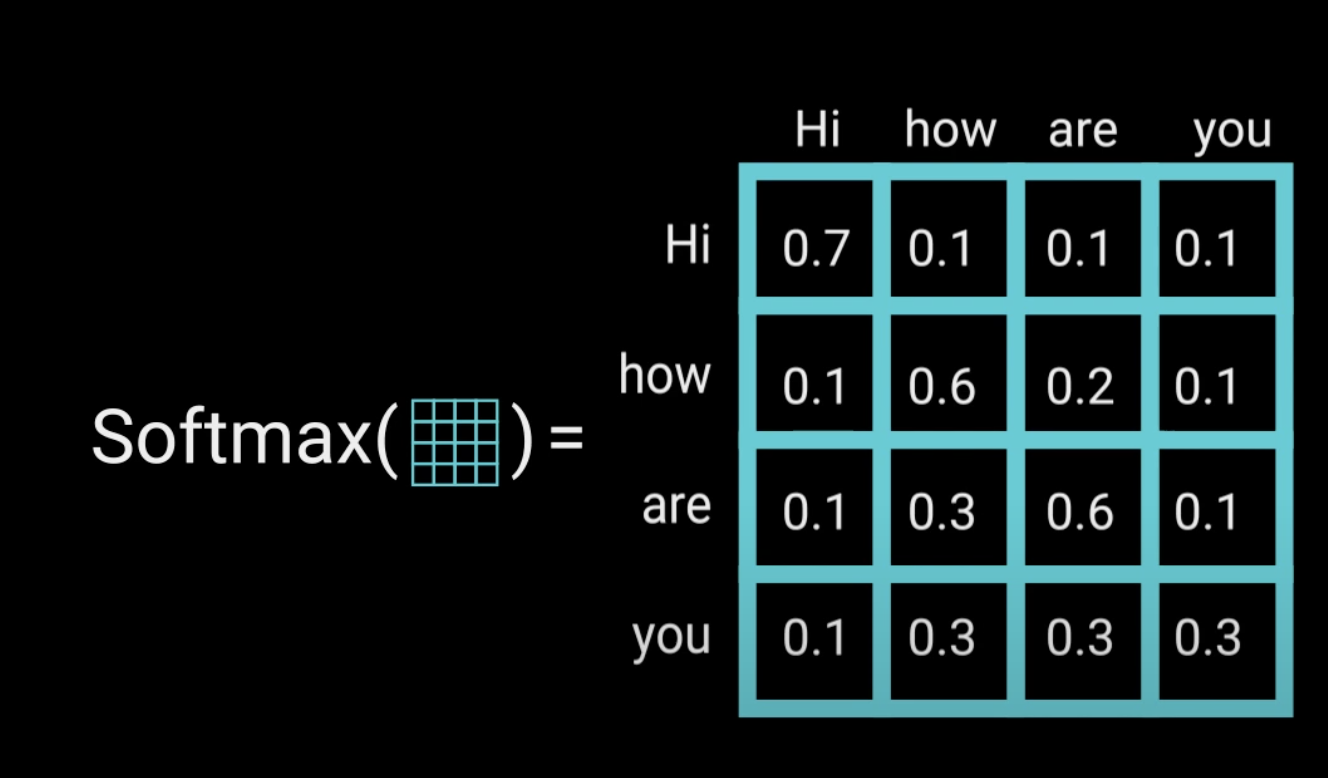

In [13]:
# Normalize the scores matrix so that the rows sum to 1.
# The scores matrix is normalized previous to the softmax by a constant, this allows for better gradient stability.
attention_weights = torch.softmax(scores / (embed_size ** (1 / 2)), dim=3)

attention_weights.shape

torch.Size([2, 2, 4, 4])

The value vectors and the attention matrix is used in order to get a final representation of a token vector that has information about the entire sequence.

In [14]:
# Get value vectors.
values = linear_layer_for_values(x_reshape)
values.shape

torch.Size([2, 4, 2, 256])

Notice that the `attention` matrix contains information of how a word is related to each other.

In the following step, the `attention` matrix is updated by including the `value` vector of each token.

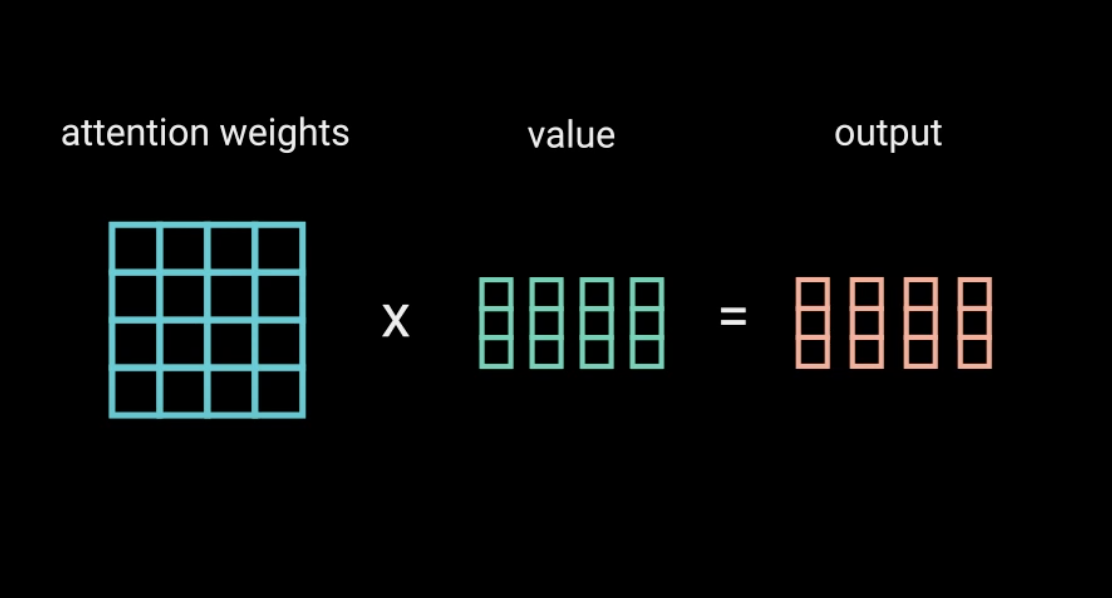

In [15]:
# The attention matrix and the value vectors are combined.
output = torch.einsum("nhql,nlhd->nqhd", [attention_weights, values])

output.shape

torch.Size([2, 4, 2, 256])

Finaly, the vectors in the `output` are:
- 1) concatenated, in order to get back to a tensor with dimensions: sequence, tokens, token-size
- 2) and passed through an additional linear layer to allow further transformation.

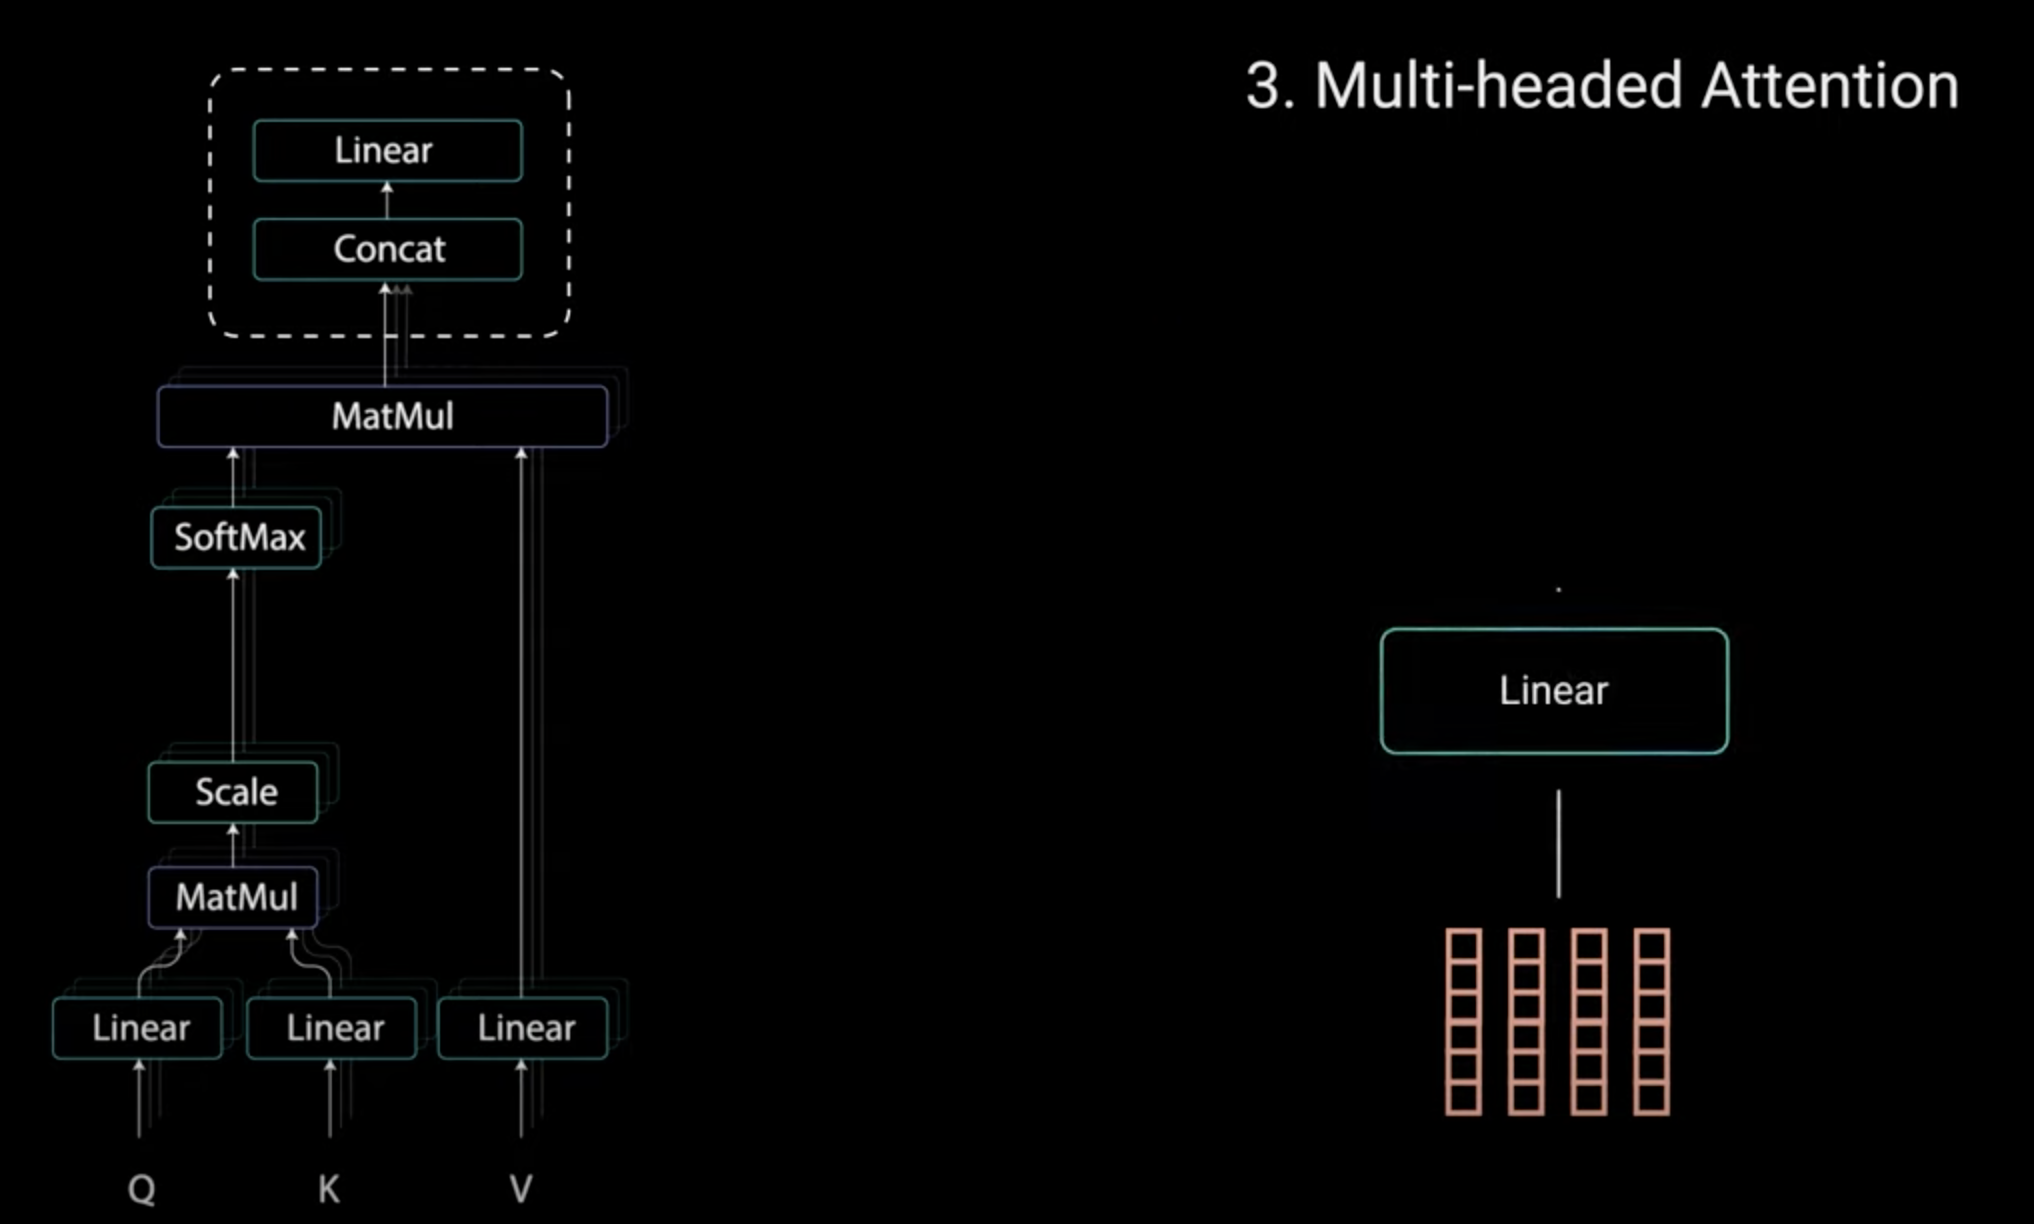

In [16]:
linear_layer_for_output = nn.Linear(heads * head_dim, embed_size)
linear_layer_for_output

Linear(in_features=512, out_features=512, bias=True)

In [17]:
# Concatenate, in order to get back to a tensor with dimensions: sequence, tokens, token-size
concatenated_output = output.reshape(
    N, 
    x.shape[1], 
    heads * head_dim)
    
# Additional linear layer to allow further transformation.
out = linear_layer_for_output(concatenated_output)

out.shape

torch.Size([2, 4, 512])

In here we conclude the Multi-Head attention mechanism which is core to understand transformer and modern NLP Neural Net architectures,